<a href="https://colab.research.google.com/github/AlexKressner/Vorlesung-Business-Intelligence-Anwendungen/blob/main/Machine_Learning_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Machine Learning: Regression, Beispiel Rossmann, Absatzprognose

## 1.1 Daten aus Goolge-Drive importieren

In [ ]:
import pandas as pd

In [ ]:
# Google-Drive einbinden
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dtypes= {
    "Store":"str",
    "DayOfWeek":"str",
#    "Open":"str",
#    "Promo":"str",
    "StateHoliday":"str",
#    "SchoolHoliday":"str",
}

In [ ]:
sales = pd.read_csv("/content/drive/MyDrive/DHBW/BI/Daten/Rossmann/sales.csv", dtype=dtypes, parse_dates=["Date"])
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
store_sample = sales.Store.sample(n=100, random_state=1)
sales = sales[sales.Store.isin(store_sample)]

## 1.2 Erster Überblick zum Datensatz

In [ ]:
# Kopfzeile der Daten
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
16,17,5,2015-07-31,8430,946,1,1,0,1
23,24,5,2015-07-31,14190,1082,1,1,0,1
38,39,5,2015-07-31,8336,929,1,1,0,1
43,44,5,2015-07-31,6670,665,1,1,0,1
45,46,5,2015-07-31,7628,775,1,1,0,0


In [ ]:
# Größe des Datensatzes
sales.shape

(82778, 9)

In [ ]:
sales.describe()

,Sales,Customers,Open,Promo,SchoolHoliday
count,82778.000000,82778.000000,82778.000000,82778.000000,82778.000000
mean,5782.618486,659.655065,0.835282,0.381454,0.179746
std,3604.587854,468.422805,0.370928,0.485747,0.383978
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3867.000000,416.000000,1.000000,0.000000,0.000000
50%,5929.000000,626.000000,1.000000,0.000000,0.000000
75%,7888.000000,875.000000,1.000000,1.000000,0.000000
max,28768.000000,3804.000000,1.000000,1.000000,1.000000


## 1.3 Vorgehensmodell zum Training eines ML-Modells
Bitte vergleichen Sie dazu die Ausführungen in der Vorlesungsunterlage!

### 1.3.1 Datensatz in Features und Target teilen
Zunächst einmal müssen wir unterscheiden, was vorhergesagt werden soll (**Target**) und welche Merkmale dazu genutzt werden sollen (**Features**).

#### FEATURES

In [ ]:
# Features, d.h. womit lässt sich der Immobilienpreis vorhersagen!
X = sales.drop(columns="Sales")
X.head()

,Store,DayOfWeek,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday
16,17,5,2015-07-31,946,1,1,0,1
23,24,5,2015-07-31,1082,1,1,0,1
38,39,5,2015-07-31,929,1,1,0,1
43,44,5,2015-07-31,665,1,1,0,1
45,46,5,2015-07-31,775,1,1,0,0


**Frage**: Welche weiteren Features, die für die Prognose relevant sein könnten, lassen sich aus den vorhandenen Daten ableiten?

In [ ]:
X["MonthOfYear"] = X.Date.dt.month

In [ ]:
X["Year"] = X.Date.dt.year - X.Date.dt.year.min()

In [ ]:
X["Trend"] = (X.Date.dt.week + X.Year*53).astype("int")

<ipython-input-95-01d36bdc0c40>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  X["Trend"] = (X.Date.dt.week + X.Year*53).astype("int")


In [ ]:
X.drop(columns=["Store","Date", "Year"], inplace=True)

In [ ]:
X.head()

,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,MonthOfYear,Trend
16,5,946,1,1,0,1,7,137
23,5,1082,1,1,0,1,7,137
38,5,929,1,1,0,1,7,137
43,5,665,1,1,0,1,7,137
45,5,775,1,1,0,0,7,137


#### TARGET

In [ ]:
# Target, d.h. was soll prognostiziert werden!
y = sales["Sales"]
y.head()

16     8430
23    14190
38     8336
43     6670
45     7628
Name: Sales, dtype: int64

In [ ]:
X.shape, y.shape

((82778, 8), (82778,))

### 1.3.2 Datensatz in Trainings- und Testmenge aufteilen

Bevor wir gleich zu der Aufteilung in Trainings- & Testdaten zum Training des ML-Verfahrens kommen, müssen die nicht-numerischen Daten passend aufbereitet werden. Das Vorgehen ist dabei immer gleich. Zur Illustration nutzen wir die  die ersten 5 Eintragungen in der Spalte `Verkaufsmonat`.

In [ ]:
example = sales["Store"].head()
example

16    17
23    24
38    39
43    44
45    46
Name: Store, dtype: object

Wenn wir mit dem Package `sklearn` und den darin verfügbaren ML-Algorithmen arbeiten, müssen wir die Datenstrutkur umwandeln. Dazu nutzen wir die Funktion `get_dummies` wie in der unteren Codezeile dargestellt.

In [ ]:
example_dummies = pd.get_dummies(example)
example_dummies

,17,24,39,44,46
16,1,0,0,0,0
23,0,1,0,0,0
38,0,0,1,0,0
43,0,0,0,1,0
45,0,0,0,0,1


**Frage**: Die beiden DataFrames `example` und `example_dummies` enthalten die gleichen Informationen. Bitte erläutern Sie die Systematik der Umwandlung!

Wir können die Funktion `get_dummies` auf den gesamten Datensatz oder ausgewählte Spalten anwenden.



In [ ]:
X = pd.get_dummies(X, columns=["DayOfWeek","MonthOfYear","StateHoliday"])
X.head()

,Customers,Open,Promo,SchoolHoliday,Trend,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,...,MonthOfYear_7,MonthOfYear_8,MonthOfYear_9,MonthOfYear_10,MonthOfYear_11,MonthOfYear_12,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
16,946,1,1,1,137,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
23,1082,1,1,1,137,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
38,929,1,1,1,137,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
43,665,1,1,1,137,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
45,775,1,1,0,137,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


Bei der Aufteilung der Daten in Test- und Trainingsmenge hilft die Funktion `train_test_split`.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Training Algorithmus: X_train (Features), y_train (Target)
# Test des Algorithmus (Bewertung): X_test, y_test
#     1) Algorithmus bekommt Daten (X_test), die er noch nicht kennt & macht Prognose
#     2) Vergleich Prognose mit tatsächlichen Werte (y_test) --> Bewertung

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

**Trainingsdaten:** Das jeweilige ML-Verfahren kennt `y_train` (Target, d.h. Immobilienpreis) und `X_train` (Features, d.h. die zugehörigen Merkmale der Immobilie) und versucht einen Zusammenhang zwischen diesen zu lernen!

In [ ]:
y_train.head()

93296      3801
803173     3987
431326     3373
454795     6777
720852    10670
Name: Sales, dtype: int64

In [ ]:
X_train.head()

,Customers,Open,Promo,SchoolHoliday,Trend,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,...,MonthOfYear_7,MonthOfYear_8,MonthOfYear_9,MonthOfYear_10,MonthOfYear_11,MonthOfYear_12,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
93296,341,1,0,0,125,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
803173,523,1,0,1,28,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
431326,413,1,0,0,77,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
454795,563,1,1,0,74,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
720852,1099,1,1,0,39,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


### 1.3.3 Modell auswählen

Für Regressions- und Klassifikationsprobleme gibt es eine Unmenge an ML-Verfahren. Eine Übersicht finden Sie [hier](https://scikit-learn.org/stable/). Wir werden das Verfahren `Random Forest` verwenden. Es gehört zu den besten und robustestens Verfahren im Bereich Machine Learning und wird aus diesem Grund häufig in der Praxis eingesetzt.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor()

### 1.3.4 Modell trainieren

Das Random Forest Verfahren versucht nun einen Zusammenhang zwischen den Features und dem Target zu lernen und minimiert dabei ein Fehlermaß. In der Grundeinstellung wird die Summe der quadrierten Fehler minimiert, d.h. $∑(y_i - \hat{y}_i)^2$ mit $y=$Preis Immobilie $i$ und $\hat{y}=$Prognose Preis Immobilie $i$.

In [ ]:
model.fit(X_train, y_train)

RandomForestRegressor()

### 1.3.5 Modell anwenden

Zu diesem Zweck nutzen wir nun die **Testdaten**. Das ML-Verfahren erhält die Daten `X_test`, d.h. die Merkmale einer Immobilie und wendet die gelernten Zusammenhänge zur Prognose des Targets an!

In [ ]:
X_test.head()

,Customers,Open,Promo,SchoolHoliday,Trend,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,...,MonthOfYear_7,MonthOfYear_8,MonthOfYear_9,MonthOfYear_10,MonthOfYear_11,MonthOfYear_12,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
767861,687,1,1,1,33,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
788616,2274,1,0,1,30,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
578050,519,1,0,0,58,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
485961,422,1,0,1,70,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
684963,791,1,1,1,43,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0


In [ ]:
y_pred = model.predict(X_test)
y_pred[:10]

array([8365.97      , 8326.37      , 4127.58      , 4394.49      ,
       7458.95      , 7834.155     , 6816.13      ,    0.        ,
       5443.65083333, 7146.40333333])

### 1.3.6 Modell evaluieren

Nachdem nun Prognosewerte durch das angelernte Verfahren berechnet wurden, können wir diese mit den tatsächlichen Werten des Target, also den tatsächlichen Immobilienpreisen vergleichen (`y_test`). Daraus können wir dann die Güte eines Verfahrens ableiten!

In [ ]:
import sklearn.metrics
import matplotlib.pyplot as plt

In [ ]:
# Genauigkeit des Modells auf der Testmenge, mittlerer absoluter Fehler 
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
mae

938.4986970658985

In [ ]:
(mae / y_test.mean())*100

16.21869673064409

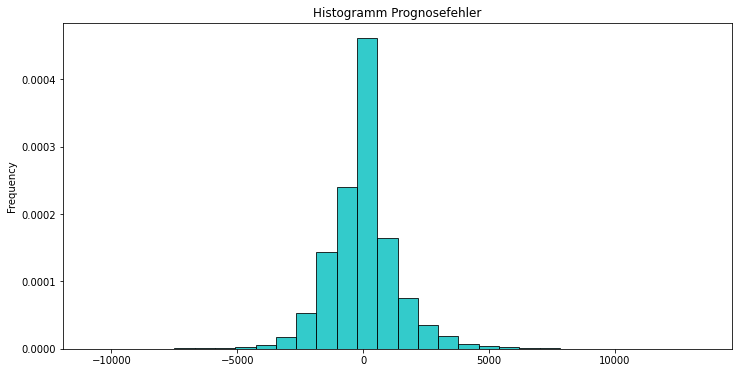

In [ ]:
(y_test - y_pred).plot(
    kind="hist",
    title= "Histogramm Prognosefehler",
    figsize=(12,6),
    color="c",
    edgecolor='k',
    density=True,
    alpha=0.8, 
    bins=30    
    )
plt.show()

### 1.3.7 Modell anwenden

In [ ]:
features = X_test.head(1).copy()
features

,Customers,Open,Promo,SchoolHoliday,Trend,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,...,MonthOfYear_7,MonthOfYear_8,MonthOfYear_9,MonthOfYear_10,MonthOfYear_11,MonthOfYear_12,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
767861,687,1,1,1,33,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
y_test.head(1)

767861    10101
Name: Sales, dtype: int64

In [ ]:
model.predict(features)

array([8365.97])

In [ ]:
features["Promo"]= 0

In [ ]:
model.predict(features)

array([6447.97])

In [ ]:
features["DayOfWeek_1"]=0
features["DayOfWeek_5"]=1

In [ ]:
model.predict(features)

array([5979.495])

### 1.3.8 Bedeutung der Feautres verstehen

In [ ]:
feature_importances = pd.DataFrame(
    model.feature_importances_, index=X.columns, columns=["Feature Importance"]
)

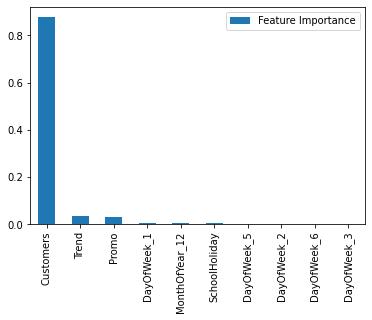

In [ ]:
feature_importances.sort_values(by="Feature Importance", ascending=False).head(10).plot(
    kind="bar"
)

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
feature_importance = permutation_importance(model, 
                       X_test, 
                       y_test,
                       n_repeats=30,
                       random_state=0
                       )

In [ ]:
for i in feature_importance.importances_mean.argsort()[::-1]:
  if feature_importance.importances_mean[i] - 2 * feature_importance.importances_std[i] > 0:
    print(f"{X_test.columns[i]:<20}"
    f"{feature_importance.importances_mean[i]:.3f}"
    f" +/- {feature_importance.importances_std[i]:.3f}")

Customers           1.417 +/- 0.012
Promo               0.081 +/- 0.003
MonthOfYear_12      0.014 +/- 0.001
DayOfWeek_1         0.012 +/- 0.001
DayOfWeek_6         0.006 +/- 0.000
Trend               0.005 +/- 0.001
DayOfWeek_7         0.003 +/- 0.000
SchoolHoliday       0.002 +/- 0.000
StateHoliday_0      0.001 +/- 0.000
StateHoliday_c      0.000 +/- 0.000
Open                0.000 +/- 0.000


# 2 Machine Learning, Klassifikation, Beispiel Diabetes
Im nachfolgenden Beispiel werden wir ein ML-Verfahren einsetzen, um anhand von Untersuchungsergebnissen vorherzusagen, ob ein Patient Diabetes hat. Es handelt sich dabei um eine Klassifikationsproblem (Diabetes/ keine Diabetes). Wir verwenden einen Datensatz mit folgenden Informationen:
1. Anzahl Schwangerschaften
1. Glukosekonzentration nach Glukosetoleranztest
1. Blutdruck (mm Hg)
1. Dicke der Trizepshautfalte (mm)
1. Insulinwert (mu U/ml)
1. Body mass index 
1. Diabetesvorbelastungsfunktion
1. Alter (Jahre)
1. Diabetes (0/1)

Die relevanten Daten haben die folgende Form:

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DHBW/BI/Daten/Diabetes/diabetes.txt")
data.head()

,schwangerschaften,glukose_konzentration,blutdruck,dicke_trizepshautfalte,insulin_wert,bmi,diabetes_vorbelastung,alter,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2.1 Datensatz in Features und Target teilen

Wie bereits zuvor müssen wir unterscheiden, was vorhergesagt werden soll (**Target**) und welche Merkmale dazu genutzt werden sollen (**Features**).

In [ ]:
# Features, d.h. womit lässt sich Diabetes prognostizeren!
X = data.drop(columns="diabetes")
X.head()

,schwangerschaften,glukose_konzentration,blutdruck,dicke_trizepshautfalte,insulin_wert,bmi,diabetes_vorbelastung,alter
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [ ]:
# Target, d.h. was soll prognostiziert werden!
y = data["diabetes"]
y.head()

0    1
1    0
2    1
3    0
4    1
Name: diabetes, dtype: int64

## 2.2 Datensatz in Trainings- und Testmenge aufteilen
Erneut müssen wir die Daten aufteilen. Da wir ausschließlich mit numerischen Daten arbeiten, müssen wir keine Datenaufbereitung über `pd.get_dummies` vornehmen.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# X und y werden in Trainings- und Testmenge aufgeteilt, so dass die Testmenge 20% der vorhandenen Daten hat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [ ]:
y_train.head()

468    1
478    0
107    0
304    0
515    1
Name: diabetes, dtype: int64

In [ ]:
X_train.head()

,schwangerschaften,glukose_konzentration,blutdruck,dicke_trizepshautfalte,insulin_wert,bmi,diabetes_vorbelastung,alter
468,8,120,0,0,0,30.0,0.183,38
478,8,126,74,38,75,25.9,0.162,39
107,4,144,58,28,140,29.5,0.287,37
304,3,150,76,0,0,21.0,0.207,37
515,3,163,70,18,105,31.6,0.268,28


## 2.3 Modell auswählen

Erneut verwenden wir das Verfahren `Random Forest`. Sie müssen allerdings darauf achten, dass Sie einen Random Forest zur Klassifikation importieren. Aus diesem Grund verwenden wir das Verfahren `RandomForestClassifier`. Für die Regressionaufgabe hatten wir das Verfahren `RandomForestRegressor` genutzt. Achten Sie auf diesen wichtigen Unterschied!

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier()

## 2.4 Modell trainieren

Das Random Forest Verfahren versucht nun einen Zusammenhang zwischen den Features und dem Target zu lernen und minimiert dabei ein Fehlermaß. Letzteres misst den Grad der Fehlklassifikation. Beispiel für Fehlklassifikation: Das Modell prognostiziert Diabetes für einen Patienten, in der Realität liegt die Erkrankung aber nicht vor.

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier()

## 2.5 Modell anwenden

Das ML-Verfahren erhält die Daten `X_test`, d.h. die Untersuchungsergebnisse mit den relevanten Merkmalen und wendet die gelernten Zusammenhänge zur Prognose des Targets an, d.h. dem Vorhandensein von Diabetes (0/1)!

In [ ]:
X_test.head()

,schwangerschaften,glukose_konzentration,blutdruck,dicke_trizepshautfalte,insulin_wert,bmi,diabetes_vorbelastung,alter
51,1,101,50,15,36,24.2,0.526,26
378,4,156,75,0,0,48.3,0.238,32
27,1,97,66,15,140,23.2,0.487,22
579,2,197,70,99,0,34.7,0.575,62
86,13,106,72,54,0,36.6,0.178,45


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0])

In [ ]:
y_test.values

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0])

In [ ]:
pd.DataFrame({"Vorhersage":pd.Series(y_pred), "Beobachtung":pd.Series(y_test.values)},).head(10)

,Vorhersage,Beobachtung
0,0,0
1,1,1
2,0,0
3,1,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


## 2.6 Modell evaluieren

Die Modellbewertung erfolgt bei der Klassifikation regelmäßg nach dem Kriterium der "Accuracy" (andere kommen aber auch zum Einsatz). Die Accuracy setzt die Anzahl der korrekten Klassifikation in das Verhältnis zur Anzahl aller Beobachtungen. Dementsprechend stellt sie den Anteil der korrekten Klassifikationen dar.

In [ ]:
sklearn.metrics.accuracy_score(y_test, y_pred) * 100

75.97402597402598

In [ ]:
neue_person = X_test.head(1).copy()
neue_person

,schwangerschaften,glukose_konzentration,blutdruck,dicke_trizepshautfalte,insulin_wert,bmi,diabetes_vorbelastung,alter
51,1,101,50,15,36,24.2,0.526,26


In [ ]:
y_test.head(1)

51    0
Name: diabetes, dtype: int64

In [ ]:
neue_person["schwangerschaften"] = 10
neue_person["blutdruck"] = 150
neue_person["bmi"] = 35
neue_person["alter"] = 70
neue_person["dicke_trizepshautfalte"] = 70
neue_person["glukose_konzentration"] = 170
neue_person

,schwangerschaften,glukose_konzentration,blutdruck,dicke_trizepshautfalte,insulin_wert,bmi,diabetes_vorbelastung,alter
51,10,170,150,70,36,35,0.526,70


In [ ]:
model.predict(neue_person)

array([1])

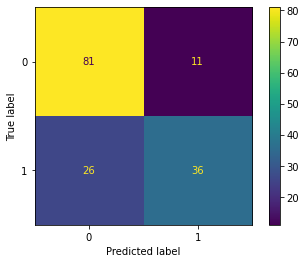

In [ ]:
conf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
disp.plot()
plt.show()

In [ ]:
feature_importances = pd.DataFrame(
    model.feature_importances_, index=X.columns, columns=["Feature Importance"]
)

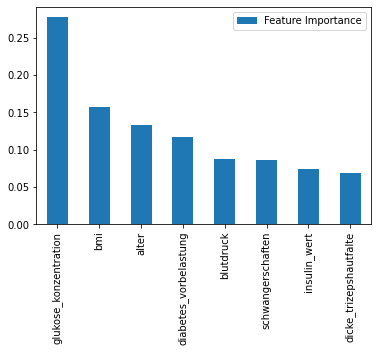

In [ ]:
feature_importances.sort_values(by="Feature Importance", ascending=False).head(10).plot(
    kind="bar"
)

# 3 Aufgabe: Prognose von Umsätzen

Der Online Autohändler AutoStar plant seinen Marketing-Mix, d.h. wie viel Geld soll in die verschiedenen Marketingkanäle "TV", "Radio", "Social Media" und "Influencer" investiert werden. Aus der Vergangenheit liegen Daten vor, die das investierte Geld in die Marketingkanäle sowie den erzielten Umsatz wiedergeben. Es ist nun Ihre Aufgabe ein Modell zu entwickeln, welches den Umsatz in Abhängigkeit der eingesetzten Mittel für die verschiedenen Marketingkanäle (TV, Radio, Social Media & Influencer) prognostizert. Die Daten finden Sie im Moodle-Raum.